In [ ]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import Lasso, Ridge

from sklearn.metrics import root_mean_squared_error
from sklearn.model_selection import train_test_split, GridSearchCV

In [99]:
data_pd = pd.read_csv('final_df.csv')
data_pd = data_pd.fillna(0)

train_df, test_df = train_test_split(data_pd, test_size=0.5)

dropped_columns = ['Unnamed: 0', 'Player', 'Nation', 'Pos', 'Squad', 'Born', '90s', 'Matches', 'League', 'Market Value']

In [100]:
train_df_dropped_cols = train_df.drop(dropped_columns, axis=1)
train_arr = train_df_dropped_cols.to_numpy()
test_df_dropped_cols = test_df.drop(dropped_columns, axis=1)
test_arr = test_df_dropped_cols.to_numpy()

train_features_sc = StandardScaler()
train_features_norm = train_features_sc.fit_transform(train_arr)
#data2 = data.copy()
test_features_norm = train_features_sc.transform(test_arr)

train_mktval = train_df['Market Value'].to_numpy().reshape(-1, 1)
test_mktval = test_df['Market Value'].to_numpy().reshape(-1, 1)
train_mktval_sc = StandardScaler()
train_mktval_norm = train_mktval_sc.fit_transform(train_mktval)
test_mktval_norm = train_mktval_sc.transform(test_mktval)

#(train_features_norm, test_features_norm, train_mktval_norm, test_mktval_norm)

In [101]:
num_components = 25

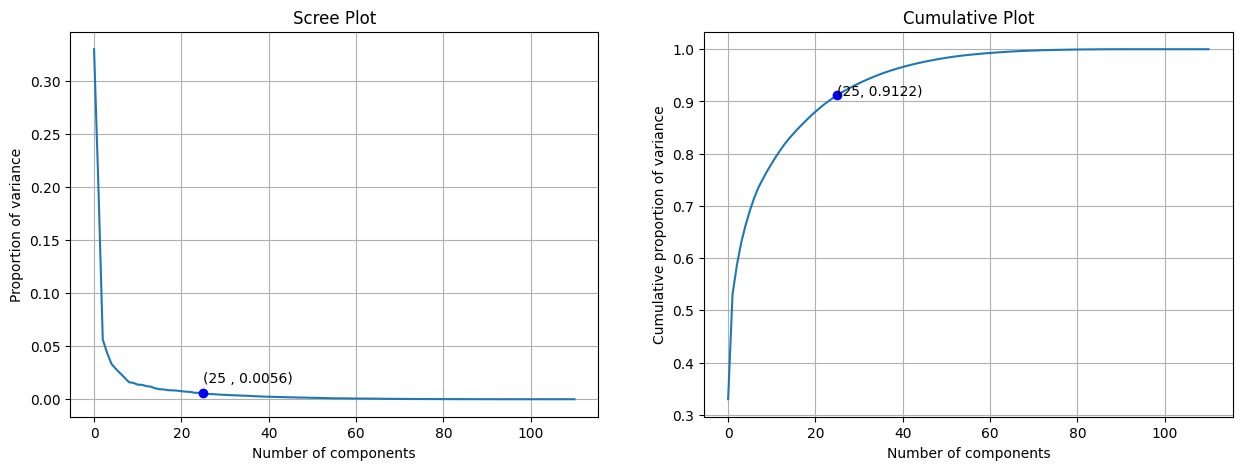

In [102]:
pca = PCA()
pca.fit(train_features_norm)
fig, axs = plt.subplots(1,2, figsize=(15, 5))
axs[0].plot(pca.explained_variance_ratio_[:])
# scree plot
axs[0].set_title('Scree Plot')
axs[0].set_xlabel('Number of components')
axs[0].set_ylabel('Proportion of variance')
axs[0].text(num_components,
            pca.explained_variance_ratio_[num_components]+0.01,
            f'({num_components} , {pca.explained_variance_ratio_[num_components]:.4f})')
axs[0].plot(num_components, pca.explained_variance_ratio_[num_components], 'bo')
axs[0].grid(True)

c_sum = np.cumsum(pca.explained_variance_ratio_)
axs[1].plot(c_sum)
axs[1].set_title('Cumulative Plot')
axs[1].set_xlabel('Number of components')
axs[1].set_ylabel('Cumulative proportion of variance')
axs[1].text(num_components, c_sum[num_components], f'({num_components}, {c_sum[num_components]:.4f})')
axs[1].plot(num_components, c_sum[num_components], 'bo')
axs[1].grid(True)


In [103]:
for i in range(5):
    sorted_pca = np.argsort(pca.components_[i])[-5:][::-1]
    cols_upper = []
    for a1 in sorted_pca:
        cols_upper.append(train_df_dropped_cols.columns[a1])
    print(cols_upper)

    sorted_pca = np.argsort(pca.components_[i])[:5]
    cols_lower = []
    for a1 in sorted_pca:
        cols_lower.append(train_df_dropped_cols.columns[a1])
    print(cols_lower)
    print()

['Touches_Touches', 'Touches_Live', 'Receiving_Rec', 'Performance_Recov', 'Carries_Carries']
['Take-Ons_Tkld%', 'Age', 'Challenges_Tkl%', 'Expected_A-xAG', 'Medium_Cmp%']

['Touches_Def 3rd', 'Touches_Def Pen', 'Clr', 'Blocks_Sh', 'Total_PrgDist']
['Standard_Sh/90', 'Standard_SoT/90', 'Carries_CPA', 'Touches_Att Pen', 'Standard_SoT']

['Aerial Duels_Won', 'Aerial Duels_Lost', 'Expected_npxG/Sh', 'Expected_npxG', 'Standard_Gls']
['Performance_Crs', 'CrsPA', 'Standard_Dist', 'SCA Types_PassDead', 'SCA_SCA90']

['Tackles_Mid 3rd', 'Tackles_Tkl', 'Tackles_TklW', 'Performance_TklW', 'Performance_Fls']
['Standard_FK', 'Carries_PrgDist', 'Medium_Cmp', 'GCA Types_PassDead', 'Total_PrgDist']

['Total_Cmp%', 'Short_Cmp%', 'Medium_Cmp%', 'Expected_np:G-xG', 'Expected_G-xG']
['SCA Types_PassDead', 'Standard_FK', 'Standard_PKatt', 'Standard_PK', 'Aerial Duels_Lost']



Text(0, 0.5, 'r2 score')

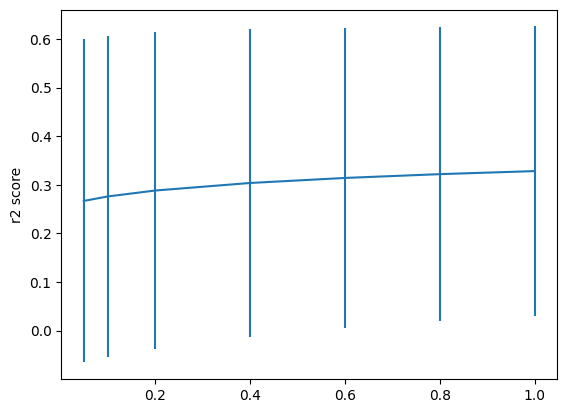

In [104]:
reg = Ridge(random_state=123, max_iter=100)
alpha_vals = [0.05, 0.1, 0.2, 0.4, 0.6, 0.8, 1]
grid_search = GridSearchCV(reg, param_grid={'alpha':alpha_vals},cv=5)
cv = grid_search.fit(train_features_norm, train_mktval_norm)
results_pd = pd.DataFrame(cv.cv_results_)
scores = results_pd['mean_test_score']
scores_std = results_pd['std_test_score']
plt.errorbar(alpha_vals, scores, scores_std)
plt.ylabel('r2 score')

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 19 stored elements and shape (1, 111)>

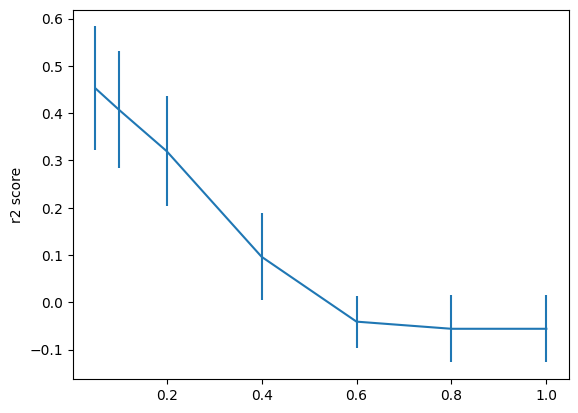

In [171]:
reg = Lasso(random_state=123, max_iter=100)
alpha_vals = [0.05, 0.1, 0.2, 0.4, 0.6, 0.8, 1]
grid_search = GridSearchCV(reg, param_grid={'alpha':alpha_vals},cv=5)
cv = grid_search.fit(train_features_norm, train_mktval_norm)
results_pd = pd.DataFrame(cv.cv_results_)
scores = results_pd['mean_test_score']
scores_std = results_pd['std_test_score']
plt.errorbar(alpha_vals, scores, scores_std)
plt.ylabel('r2 score')
best_model = cv.best_estimator_
best_model.sparse_coef_

In [184]:
for i in range(len(train_df_dropped_cols.columns)):
    if best_model.coef_[i]!=0:
        print(train_df_dropped_cols.columns[i], best_model.coef_[i])

Age -0.25315705830824736
Standard_Gls 0.26284745023503897
Standard_SoT 0.18115484814977656
Standard_Dist -0.041645730087810987
Expected_xG 0.07496386309184971
Expected_npxG 0.029576712930138773
Total_Cmp% 0.08361190925280525
Short_Cmp 0.24935208060268052
Expected_A-xAG 0.007827792656913137
PPA 0.08906804147555535
SCA_SCA90 0.05499496667807647
GCA Types_PassLive 0.01593785567114504
Tackles_Att 3rd 0.0021622752875314166
Carries_PrgDist 0.03574223622815119
Carries_CPA 0.0016734527074816715
Carries_Mis -0.1103505689744369
Performance_Fls -0.007405687301516114
Performance_Off -0.06094279240266052
Aerial Duels_Lost -0.027108325205308


In [173]:
train_df_dropped_cols.columns

Index(['Age', 'Standard_Gls', 'Standard_Sh', 'Standard_SoT', 'Standard_SoT%',
       'Standard_Sh/90', 'Standard_SoT/90', 'Standard_G/Sh', 'Standard_G/SoT',
       'Standard_Dist',
       ...
       'Performance_Crs', 'Performance_Int', 'Performance_TklW',
       'Performance_PKwon', 'Performance_PKcon', 'Performance_OG',
       'Performance_Recov', 'Aerial Duels_Won', 'Aerial Duels_Lost',
       'Aerial Duels_Won%'],
      dtype='object', length=111)

In [145]:
transformed_features_train = pca.transform(train_features_norm)[:,:num_components]
transformed_features_test = pca.transform(test_features_norm)[:,:num_components]

In [146]:
transformed_features_test.shape

(312, 25)

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 21 stored elements and shape (1, 25)>

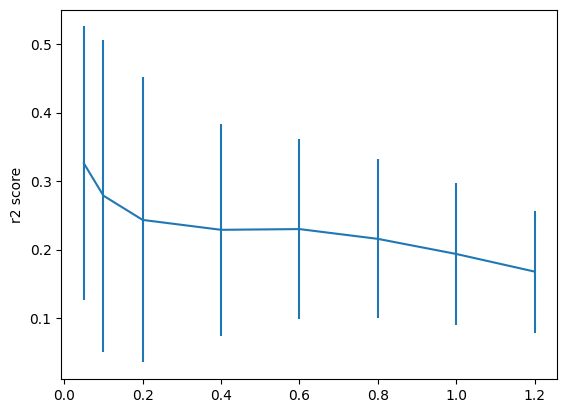

In [158]:
reg = Lasso(random_state=123, max_iter=100)
alpha_vals = [0.05, 0.1, 0.2, 0.4, 0.6, 0.8, 1, 1.2]
grid_search = GridSearchCV(reg, param_grid={'alpha':alpha_vals},cv=5)
cv = grid_search.fit(transformed_features_train, train_mktval_norm)
results_pd = pd.DataFrame(cv.cv_results_)
scores = results_pd['mean_test_score']
scores_std = results_pd['std_test_score']
plt.errorbar(alpha_vals, scores, scores_std)
plt.ylabel('r2 score')
best_model = cv.best_estimator_
best_model.sparse_coef_

Text(0, 0.5, 'r2 score')

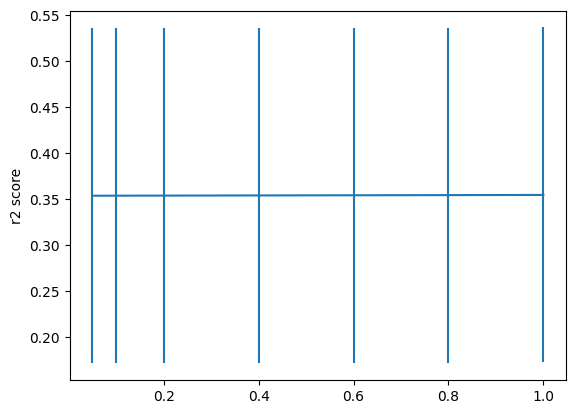

In [167]:
reg = Ridge(random_state=123, max_iter=100)
alpha_vals = [0.05, 0.1, 0.2, 0.4, 0.6, 0.8, 1]
grid_search = GridSearchCV(reg, param_grid={'alpha':alpha_vals},cv=5)
cv = grid_search.fit(transformed_features_train, train_mktval_norm)
results_pd = pd.DataFrame(cv.cv_results_)
scores = results_pd['mean_test_score']
scores_std = results_pd['std_test_score']
plt.errorbar(alpha_vals, scores, scores_std)
plt.ylabel('r2 score')

In [163]:
from sklearn.metrics import root_mean_squared_error

In [170]:
out =best_model.predict(transformed_features_test)
print(root_mean_squared_error(test_mktval_norm, out))
out =best_model.predict(transformed_features_train)
print(root_mean_squared_error(train_mktval_norm, out))

0.6550249342410237
0.643956573758258


In [109]:
test_score = best_model.score(test_features_norm, test_mktval_norm)
print(test_score)

0.4563078500429253


In [114]:
from sklearn.cluster import KMeans

In [160]:
b = KMeans()
b.fit(train_features_norm)

KMeans()

In [161]:
len(b.labels_)

311

ValueError: 'c' argument has 311 elements, which is inconsistent with 'x' and 'y' with size 111.

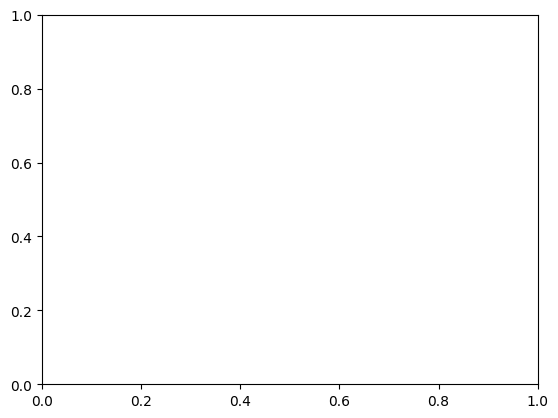

In [162]:
plt.scatter(train_features_norm[0], train_features_norm[1], c = b.labels_)